In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import torch.utils.data as Data
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import datetime as dt

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/covid_19/covid_19/covid_19_data.csv")
for i in range(306429):
  str0 = df.iloc[i,1]
  str1 = str0.split('/')
  str2 = str1[0]
  str3 = str1[1]
  str4 = str1[2]
  df.iloc[i,1] = str4 + "/" + str2 + "/" + str3
#df=pd.to_datetime(df.ObservationDate,format='%Y%m%d')
print(df)
#print(df.iloc[0,1])

           SNo ObservationDate     Province/State  ... Confirmed  Deaths  Recovered
0            1      2020/01/22              Anhui  ...       1.0     0.0        0.0
1            2      2020/01/22            Beijing  ...      14.0     0.0        0.0
2            3      2020/01/22          Chongqing  ...       6.0     0.0        0.0
3            4      2020/01/22             Fujian  ...       1.0     0.0        0.0
4            5      2020/01/22              Gansu  ...       0.0     0.0        0.0
...        ...             ...                ...  ...       ...     ...        ...
306424  306425      2021/05/29  Zaporizhia Oblast  ...  102641.0  2335.0    95289.0
306425  306426      2021/05/29            Zeeland  ...   29147.0   245.0        0.0
306426  306427      2021/05/29           Zhejiang  ...    1364.0     1.0     1324.0
306427  306428      2021/05/29    Zhytomyr Oblast  ...   87550.0  1738.0    83790.0
306428  306429      2021/05/29       Zuid-Holland  ...  391559.0  4252.0    

In [ ]:
dataset_rnn = df.groupby(['ObservationDate']).agg({'Confirmed':'sum','Recovered':'sum','Deaths':'sum'})
#dataset_rnn=dataset_rnn.rename(columns={'ObservationDate':'Date'})

dataset_rnn

,Confirmed,Recovered,Deaths
ObservationDate,,,
2020/01/22,557.0,30.0,17.0
2020/01/23,1097.0,60.0,34.0
2020/01/24,941.0,39.0,26.0
2020/01/25,1437.0,42.0,42.0
2020/01/26,2118.0,56.0,56.0
...,...,...,...
2021/05/25,167848207.0,104824935.0,3485788.0
2021/05/26,168416423.0,105380748.0,3498544.0
2021/05/27,168970791.0,106078106.0,3511297.0


In [ ]:
confirmed_rnn = dataset_rnn.drop(['Recovered','Deaths'],axis=1)
#confirmed_rnn['ObservationDate'] = pd.to_datetime(df.ObservationDate')
#confirmed_rnn = pd.to_datetime(confirmed_rnn.iloc[:,0].str.replace('/','/'),format='%Y/%M/%D')
#confirmed_rnn['ObservationDate'] =pd.to_datetime(confirmed_rnn['ObservationDate'])
#confirmed_rnn["ObservationDate"] = confirmed_rnn.index[0].replace('/','-')
#confirmed_rnn=confirmed_rnn['ObservationDate'].dt.strftime('%Y/%M/%D')
#confirmed_rnn['ObservationDate'] = pd.to_datetime(confirmed_rnn.columns[0])
#x1 = pd.to_datetime( confirmed_rnn['ObservationDate'], format='%m/%d/%Y')
#x1 = x1.dt.strftime('%Y/%m/%d')
#x1
confirmed_rnn.sort_values(by = 'ObservationDate', ascending = True, inplace = True)
confirmed_rnn

,Confirmed
ObservationDate,
2020/01/22,557.0
2020/01/23,1097.0
2020/01/24,941.0
2020/01/25,1437.0
2020/01/26,2118.0
...,...
2021/05/25,167848207.0
2021/05/26,168416423.0
2021/05/27,168970791.0


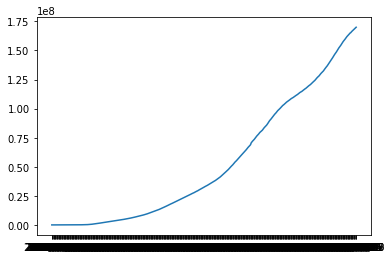

In [ ]:
plt.plot(confirmed_rnn)

In [ ]:
confirmed_rnn = confirmed_rnn.dropna()
dataset = confirmed_rnn.values
dataset = dataset.astype('float32')
max_value = np.max(dataset)
min_value = np.min(dataset)
scalar = max_value - min_value
dataset = list(map(lambda x: x / scalar, dataset))

In [ ]:
print(dataset)

[array([3.2774153e-06], dtype=float32), array([6.454802e-06], dtype=float32), array([5.5368905e-06], dtype=float32), array([8.4553785e-06], dtype=float32), array([1.2462417e-05], dtype=float32), array([1.7222612e-05], dtype=float32), array([3.2821226e-05], dtype=float32), array([3.6275163e-05], dtype=float32), array([4.8455146e-05], dtype=float32), array([5.839919e-05], dtype=float32), array([7.083218e-05], dtype=float32), array([9.8775534e-05], dtype=float32), array([0.00011698], dtype=float32), array([0.00014058], dtype=float32), array([0.00016261], dtype=float32), array([0.00018133], dtype=float32), array([0.00020236], dtype=float32), array([0.00021842], dtype=float32), array([0.00023625], dtype=float32), array([0.00025162], dtype=float32), array([0.00026362], dtype=float32), array([0.00026609], dtype=float32), array([0.00035522], dtype=float32), array([0.00039357], dtype=float32), array([0.00040619], dtype=float32), array([0.0004191], dtype=float32), array([0.00043107], dtype=float

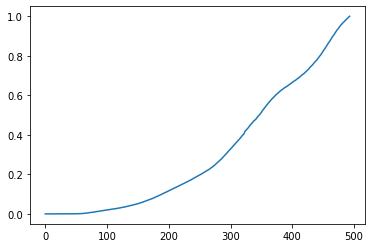

In [ ]:
plt.plot(dataset)

In [ ]:
def create_dataset(dataset, look_back=2):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [ ]:
# 创建好输入输出
data_X, data_Y = create_dataset(dataset)

In [ ]:
# 划分訓練集和測試集，70% 作为訓練集 ，30% 作为測試集
train_size = int(len(data_X) * 0.7)
test_size = len(data_X) - train_size
train_X = data_X[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X[train_size:]
test_Y = data_Y[train_size:]

In [ ]:
import torch

train_X = train_X.reshape(-1, 1, 2)
train_Y = train_Y.reshape(-1, 1, 1)
test_X = test_X.reshape(-1, 1, 2)

train_x = torch.from_numpy(train_X)
train_y = torch.from_numpy(train_Y)
test_x = torch.from_numpy(test_X)

In [ ]:
from torch import nn
from torch.autograd import Variable

In [ ]:
class lstm_reg(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super(lstm_reg, self).__init__()

        self.rnn = nn.LSTM(input_size, hidden_size, num_layers) # rnn
        self.reg = nn.Linear(hidden_size, output_size) # 回归

    def forward(self, x):
        x, _ = self.rnn(x) # (seq, batch, hidden)
        s, b, h = x.shape
        x = x.view(s*b, h) # 转换成线性层的输入格式
        x = self.reg(x)
        x = x.view(s, b, -1)
        return x

In [ ]:
net = lstm_reg(2, 4)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

In [ ]:
for e in range(1000):
    var_x = Variable(train_x)
    var_y = Variable(train_y)
    # 前向传播
    out = net(var_x)
    loss = criterion(out, var_y)
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 100 == 0: # 每 100 次输出结果
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.data))

Epoch: 100, Loss: 0.00002
Epoch: 200, Loss: 0.00002
Epoch: 300, Loss: 0.00001
Epoch: 400, Loss: 0.00001
Epoch: 500, Loss: 0.00001
Epoch: 600, Loss: 0.00001
Epoch: 700, Loss: 0.00000
Epoch: 800, Loss: 0.00000
Epoch: 900, Loss: 0.00000
Epoch: 1000, Loss: 0.00000


In [ ]:
net = net.eval() # 转换成测试模式

In [ ]:
data_X = data_X.reshape(-1, 1, 2)
data_X = torch.from_numpy(data_X)
var_data = Variable(data_X)
pred_test = net(var_data) # 测试集的预测结果

In [ ]:
# 改变输出的格式
pred_test = pred_test.view(-1).data.numpy()

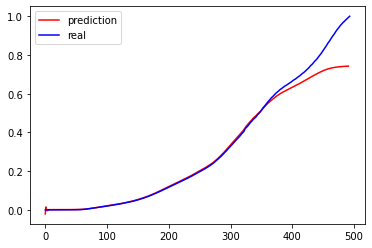

In [ ]:
# 画出实际结果和预测的结果
plt.plot(pred_test, 'r', label='prediction')
plt.plot(dataset, 'b', label='real')
plt.legend(loc='best')